# Import

In [1]:
import numpy as np
from scipy.linalg import toeplitz
from sys import getsizeof
from timeit import default_timer as time
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from numpy.linalg import inv
import functions_eq_mag as fc
import functions_fatiando as ft
import fourier_continuation as fc_c
import pickle as pickle
%matplotlib inline

# Observation and Equivalent layer grids

In [2]:
# Create a regular grid at 0m height
area = [-5000., 5000., -4000., 4000.]
shape = (100, 50)
N = shape[0]*shape[1]
xi, yi, zi = ft.gridder_regular(area, shape, z=-900.)
xi_plot, yi_plot, = xi/1000, yi/1000

# Equivalent Layer
areaj = [-5000., 5000., -4000., 4000.]
shapej = (100, 50)
Nj = shapej[0]*shapej[1]
xj, yj, zj = ft.gridder_regular(areaj, shapej, z=50)

# Model
verts1 = [[2000, -3000], [4000, -3000], [4000, 1000], [2000, 1000]]
#verts2 = [[-2000, 1000], [1000, 1000], [1000, 3000], [-2000, 3000]]
verts2 = [[-2000, 2000], [0, 2000], [0, 6000], [-2000, 6000]]
model_prism = [ft.mesher_PolygonalPrism(verts1, 900., 1500., props={'magnetization':[2,2,2]}),
               ft.mesher_PolygonalPrism(verts2, 700., 1100., props={'magnetization':[2,2,2]})]

R = 1000 #Radius
xc, yc, zc = -3000.,-2000.,2000. #Center of sphere
model_sphere = [ft.mesher_Sphere(xc, yc, zc, R, props={'magnetization':[2,2,2]})]

In [3]:
# Magnetic Configuration
inc0 = np.deg2rad(35.26)
dec0 = np.deg2rad(45.)
inc = np.deg2rad(35.26)
dec = np.deg2rad(45.)

F = np.array([np.cos(inc0)*np.cos(dec0), np.cos(inc0)*np.sin(dec0), np.sin(inc0)])
h = np.array([np.cos(inc)*np.cos(dec), np.cos(inc)*np.sin(dec), np.sin(inc)])

In [4]:
tf_prism = ft.polyprism_tf(xi, yi, zi, model_prism, np.rad2deg(inc0), np.rad2deg(dec0))
tf_sphere = ft.sphere_tf(xi, yi, zi, model_sphere, np.rad2deg(inc0), np.rad2deg(dec0))
tf_noiseless = tf_prism + tf_sphere
tf = ft.utils_contaminate(tf_noiseless, 0.5, seed=0, percent=False)

In [5]:
noise = tf-tf_noiseless
print (np.std(np.abs(noise)))

0.2960850833297832


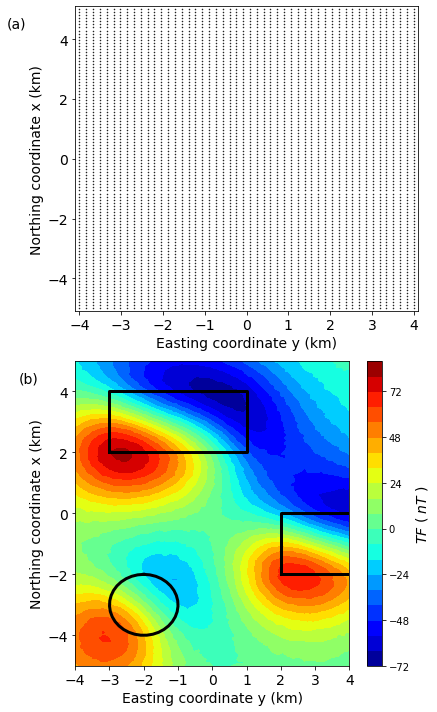

In [6]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x = xc/1000 + R/1000*np.cos(phi)
y = yc/1000 + R/1000*np.sin(phi)

x_p = [-3., -3, 1, 1, -3.]
y_p = [2., 4, 4, 2, 2.]

x_p2 = [2, 2, 6, 6, 2]
y_p2 = [-2, 0, 0, -2, -2.]

fig = plt.figure(figsize=(6,10))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(211)
plt.title('(a)', y=0.91, x=-0.17, fontsize=14)
plt.plot(yi_plot, xi_plot, 'ko', alpha=1, ms=0.5)
plt.xlim(np.min(yi_plot)-0.1,np.max(yi_plot)+0.1)
plt.ylim(np.min(xi_plot)-0.1,np.max(xi_plot)+0.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(212)
plt.title('(b)', y=0.91, x=-0.17, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
#plt.plot(yi, xi, 'ko-', alpha=0.1)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('figures/model_mag_synthetic.png', dpi=300)

# Classic Forward Problem Construction - MAG

In [7]:
# Calculo da matriz de sensibilidade
s = time()
p_c, tf_c = fc.classic_mag(xi,yi,zi,zj,F,h,N,tf)
e = time()
tcpu = e - s
print (tcpu)

8.503740800000287


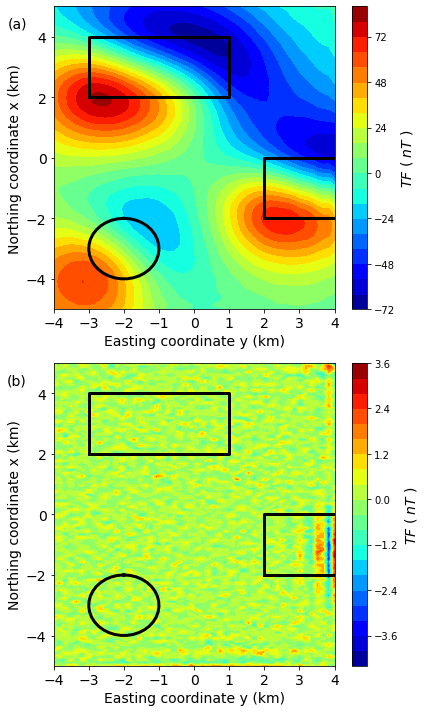

In [8]:
fig = plt.figure(figsize=(6,10))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(211)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_c,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

delta_tf = tf-tf_c
plt.subplot(212)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,delta_tf,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout();
#plt.savefig('figures/predicted_synthetic_mag.png', dpi=300)

In [9]:
mean = np.mean(np.abs(delta_tf))
print (mean)
std = np.std(np.abs(delta_tf))
print (std)

0.41181286360130687
0.37799800791994664


## Parameter Plot

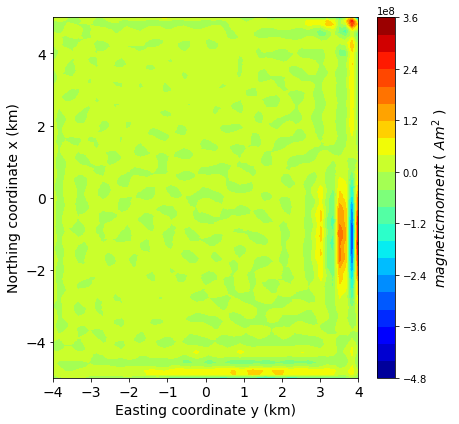

In [15]:
fig = plt.figure(figsize=(6.5,6))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,p_c,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$magnetic moment$ ( $Am^2$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout();
#plt.savefig('figures/classic_fast.png', dpi=300)

# Conjugate Gradient Least Square

### Aster CGLS implementation - no conditioning

In [16]:
itmax = 50
t = time()
p_cgls, tf_cgls = fc.cgls_eq_mag(xi,yi,zi,zj,shape,tf,F,h,itmax)
w = time()
tcpu_cgls = w - t
print (tcpu_cgls)

3.6702715000000126


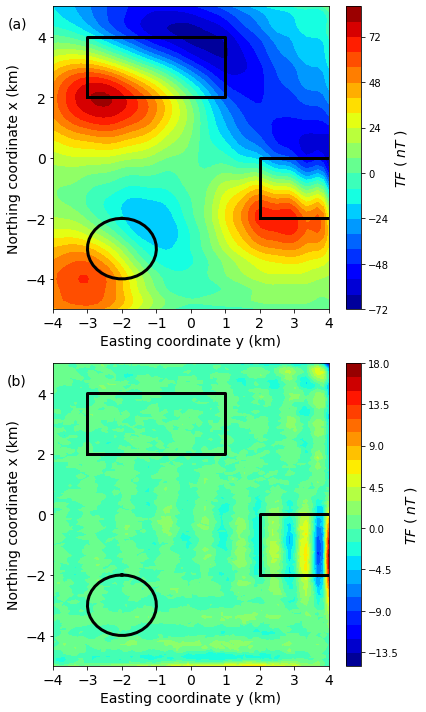

In [17]:
fig = plt.figure(figsize=(6,10))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(211)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_cgls,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

delta_tf2 = tf-tf_cgls
plt.subplot(212)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,delta_tf2,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout();
#plt.savefig('figures/predicted_cgls_mag.png', dpi=300)

In [18]:
mean = np.mean(np.abs(delta_tf2))
print (mean)
std = np.std(np.abs(delta_tf2))
print (std)

0.9977208220853329
1.3898214867318324


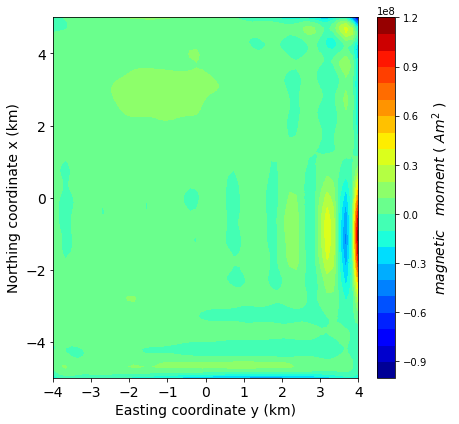

In [19]:
fig = plt.figure(figsize=(6.5,6))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,p_cgls,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$magnetic \quad moment$ ( $Am^2$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout();
#plt.savefig('figures/p_cgls.png', dpi=300)

### BCCB  matrix-vector product with Linear CGLS implementation - no conditioning

In [10]:
w = time()
itmax = 50
p_bccb,tf_bccb = fc.cgls_eq_bccb_mag(xi,yi,zi,zj,shape,tf,F,h,itmax)
t = time()
tcpu = t - w
print (tcpu)

0.16897999999991953


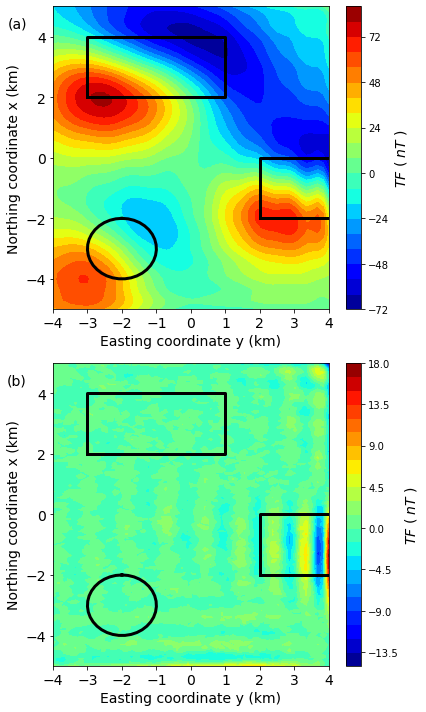

In [11]:
fig = plt.figure(figsize=(6,10))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(211)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_bccb,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

delta_tf3 = tf-tf_bccb
plt.subplot(212)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,delta_tf3,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout();
#plt.savefig('figures/predicted_bccb_mag.png', dpi=300)

In [12]:
mean = np.mean(np.abs(delta_tf3))
print (mean)
std = np.std(np.abs(delta_tf3))
print (std)

0.9974849058394604
1.3900108134157854


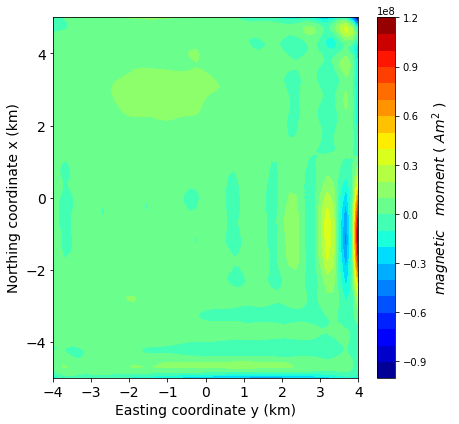

In [23]:
fig = plt.figure(figsize=(6.5,6))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,p_bccb,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$magnetic \quad moment$ ( $Am^2$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout();
#plt.savefig('figures/p_bccb.png', dpi=300)

## CGLS Convergence

In [24]:
itmax = np.arange(1,80,2)
res_list_ls = []
for k in itmax:
    p_cgls2,dobs_cgls2 = fc.cgls_eq_bccb_mag(xi,yi,zi,zj,shape,tf,F,h,k)
    norm_res_ls = np.linalg.norm(tf-dobs_cgls2)/N
    res_list_ls.append(norm_res_ls)

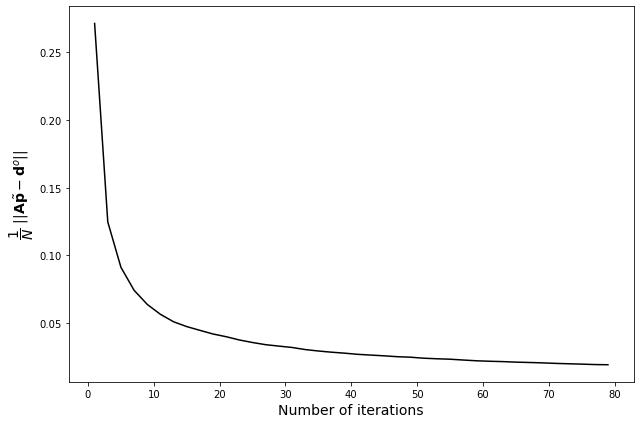

In [25]:
fig = plt.figure(figsize=(9,6))
fig.patch.set_facecolor('xkcd:white')
plt.plot(itmax,res_list_ls, 'k-')
plt.xlabel('Number of iterations', fontsize=14)
plt.ylabel('$\dfrac{1}{N} \,\,||\mathbf{A} \~{\mathbf{p}} - \mathbf{d}^o||$', fontsize=14)
plt.tight_layout();
#plt.savefig('figures/convergence_synthetic_mag.png', dpi=300)

## Upward and Downward continuation Fourier comparison

### True upward and downward data

In [26]:
zi_up = np.ones_like(zi)*(-1300)
tf_prism_up = ft.polyprism_tf(xi, yi, zi_up, model_prism, np.rad2deg(inc), np.rad2deg(dec))
tf_sphere_up = ft.sphere_tf(xi, yi, zi_up, model_sphere, np.rad2deg(inc), np.rad2deg(dec))
tf_up = tf_prism_up + tf_sphere_up
#tf_up = ft.utils_contaminate(tf_up, 0.5, seed=0, percent=False)

In [27]:
zi_down = np.ones_like(zi)*(-500)
tf_prism_down = ft.polyprism_tf(xi, yi, zi_down, model_prism, np.rad2deg(inc), np.rad2deg(dec))
tf_sphere_down = ft.sphere_tf(xi, yi, zi_down, model_sphere, np.rad2deg(inc), np.rad2deg(dec))
tf_down = tf_prism_down + tf_sphere_down
#tf_down = ft.utils_contaminate(tf_down, 0.5, seed=0, percent=False)

### Classical equivalent layer upward and downward

In [29]:
s = time()
A_up = fc.sensitivity_matrix(xi,yi,zi_up,zj,F,h,N)
tf_classical_up = A_up.dot(p_c)
e = time()
tcpu = e - s
print (tcpu, 'seconds')

2.998660299999983 seconds


In [30]:
s = time()
A_down = fc.sensitivity_matrix(xi,yi,zi_down,zj,F,h,N)
tf_classical_down = A_down.dot(p_c)
e = time()
tcpu = e - s
print (tcpu, 'seconds')

3.0569289000000026 seconds


### CGLS BCCB equivalent layer upward and downward

In [31]:
s = time()
bttb_0_up, bttb_1_up, bttb_2_up, bttb_3_up = fc.bttb_mag(xi, yi, zi_up, zj, F, h, shape)
cev_up = fc.cev_mag(bttb_0_up, bttb_1_up, bttb_2_up, bttb_3_up, shape, N)
tf_bccb_up = fc.fast_forward_bccb_mag(cev_up, p_bccb, shape, N)
e = time()
tcpu = e - s
print (tcpu)

0.0065436000000431704


In [32]:
s = time()
bttb_0_down, bttb_1_down, bttb_2_down, bttb_3_down = fc.bttb_mag(xi, yi, zi_down, zj, F, h, shape)
cev_down = fc.cev_mag(bttb_0_down, bttb_1_down, bttb_2_down, bttb_3_down, shape, N)
tf_bccb_down = fc.fast_forward_bccb_mag(cev_down, p_bccb, shape, N)
e = time()
tcpu = e - s
print (tcpu)

0.006428599999992457


### Fourier upward and downward

In [33]:
tf_fourier_up = fc_c.upcontinue(xi, yi, tf, shape, 400)

tf_fourier_down = fc_c.upcontinue(xi, yi, tf, shape, -400);

C:\Users\diego_000\Repositories\EQ_Layer_Mag-Toeplitz\code\fourier_continuation.py:56: UserWarning: Using 'height' <= 0 means downward continuation, which is known to be unstable.
  warnings.warn("Using 'height' <= 0 means downward continuation, " +


### Plot the upward continuations residuals

In [34]:
# define the scale for residuals
delta_tf_classical_up = tf_up-tf_classical_up
delta_tf_bccb_up = tf_up-tf_bccb_up
delta_tf_fourier_up = tf_up-np.ravel(tf_fourier_up)
scale_max = np.max(delta_tf_fourier_up)
scale_min = np.min(delta_tf_fourier_up)
colorbar_ranges = np.linspace(-20, 20, 21)
print (scale_min, scale_max)

-32.778689213418495 27.808615863626578


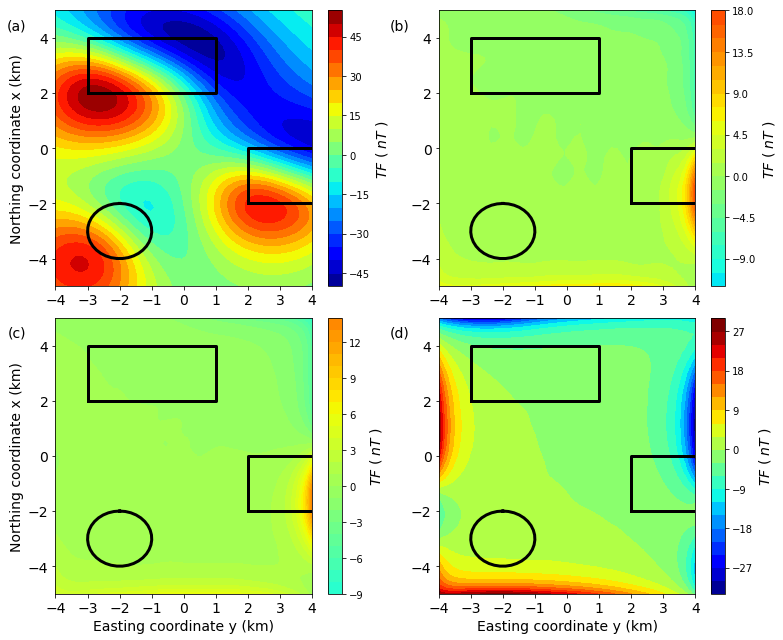

In [35]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x = xc/1000 + R/1000*np.cos(phi)
y = yc/1000 + R/1000*np.sin(phi)

x_p = [-3., -3, 1, 1, -3.]
y_p = [2., 4, 4, 2, 2.]

x_p2 = [2, 2, 6, 6, 2]
y_p2 = [-2, 0, 0, -2, -2.]

fig = plt.figure(figsize=(11,9))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(221)
plt.title('(a)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_up,22, cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(222)
plt.title('(b)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,delta_tf_bccb_up,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(223)
plt.title('(c)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,delta_tf_classical_up,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(224)
plt.title('(d)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,delta_tf_fourier_up,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.tight_layout()
#plt.savefig('figures/upward_regular.png', dpi=300)

In [36]:
print (np.mean(np.abs(delta_tf_classical_up)))
print (np.mean(np.abs(delta_tf_bccb_up)))
print (np.mean(np.abs(delta_tf_fourier_up)))

print (np.std(np.abs(delta_tf_classical_up)))
print (np.std(np.abs(delta_tf_bccb_up)))
print (np.std(np.abs(delta_tf_fourier_up)))

0.9108409009293268
1.176655611060933
4.132695016159401
1.4421501744878766
1.801070169630809
5.564364300592581


### Plot the downward continuations residuals

In [37]:
# define the scale for residuals
delta_tf_classical_down = tf_down-tf_classical_down
delta_tf_bccb_down = tf_down-tf_bccb_down
delta_tf_fourier_down = tf_down-np.ravel(tf_fourier_down)
scale_max = np.max(tf_fourier_down)
scale_min = np.min(tf_fourier_down)
colorbar_ranges = np.linspace(-45, 15, 21)
print (scale_min, scale_max)

-1320082.2440388924 1324596.6731186814


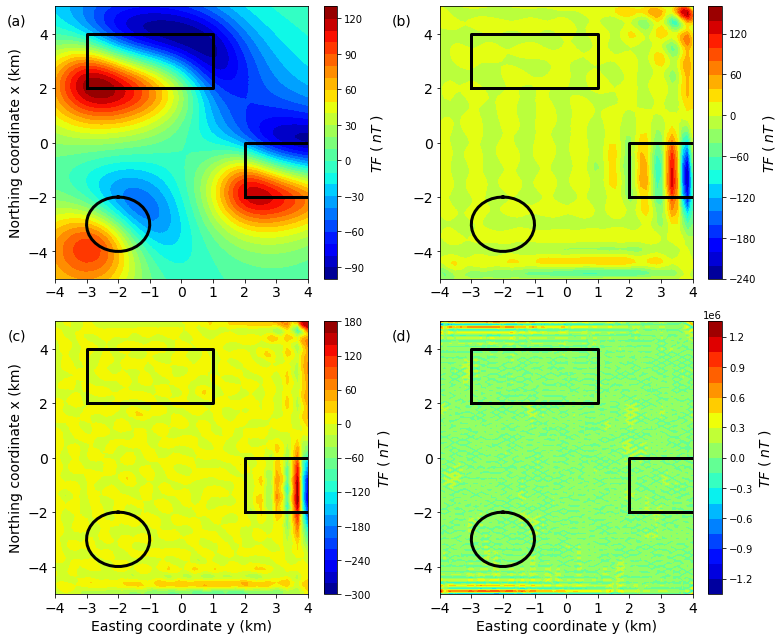

In [38]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x = xc/1000 + R/1000*np.cos(phi)
y = yc/1000 + R/1000*np.sin(phi)

x_p = [-3., -3, 1, 1, -3.]
y_p = [2., 4, 4, 2, 2.]

x_p2 = [2, 2, 6, 6, 2]
y_p2 = [-2, 0, 0, -2, -2.]

fig = plt.figure(figsize=(11,9))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(221)
plt.title('(a)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_down,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(222)
plt.title('(b)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,delta_tf_bccb_down,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(223)
plt.title('(c)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,delta_tf_classical_down,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(224)
plt.title('(d)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,delta_tf_fourier_down,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.tight_layout()
#plt.savefig('figures/downward_regular.png', dpi=300)

## Reduction to Pole

In [39]:
# Magnetic Configuration
inc_rtp = np.deg2rad(90.)
dec_rtp = np.deg2rad(0.)
F_rtp = np.array([np.cos(inc_rtp)*np.cos(dec_rtp), np.cos(inc_rtp)*np.sin(dec_rtp), np.sin(inc_rtp)])
h_rtp = np.array([np.cos(inc_rtp)*np.cos(dec_rtp), np.cos(inc_rtp)*np.sin(dec_rtp), np.sin(inc_rtp)])
#3.4641, 35.2644, 45.0
# Model
model_prism_rtp = [ft.mesher_PolygonalPrism(verts1, 900., 1500., props={'magnetization':ft.utils_ang2vec(3.4641, 90, 0)}),
               ft.mesher_PolygonalPrism(verts2, 700., 1100., props={'magnetization':ft.utils_ang2vec(3.4641, 90, 0)})]

model_sphere_rtp = [ft.mesher_Sphere(xc, yc, zc, R, props={'magnetization':ft.utils_ang2vec(3.4641, 90, 0)})]

In [40]:
### True Pole data

tf_prism_rtp = ft.polyprism_tf(xi, yi, zi, model_prism_rtp, np.rad2deg(inc_rtp), np.rad2deg(dec_rtp))
tf_sphere_rtp = ft.sphere_tf(xi, yi, zi, model_sphere_rtp, np.rad2deg(inc_rtp), np.rad2deg(dec_rtp))
tf_rtp = tf_prism_rtp + tf_sphere_rtp

In [42]:
### Classical

s = time()
A_rtp = fc.sensitivity_matrix(xi,yi,zi,zj,F_rtp,h_rtp,N)
tf_classical_rtp = A_rtp.dot(p_c)
e = time()
tcpu = e - s
print (tcpu, 'seconds')

### CGLS BCCB

s = time()
hxx_rtp, hxy_rtp, hxz_rtp, hyy_rtp, hyz_rtp, hzz_rtp = fc.h_bttb_mag(xi,yi,zi,zj,F_rtp,h_rtp,shape)
cev_rtp = fc.ones_cev_mag(hxx_rtp, hxy_rtp, hxz_rtp, hyy_rtp, hyz_rtp, hzz_rtp,shape,N,F_rtp,h_rtp)
tf_bccb_rtp = fc.fast_forward_bccb_mag(cev_rtp, p_bccb, shape, N)
e = time()
tcpu = e - s
print (tcpu)

### Fourier

s = time()
tf_fourier_rtp = ft.reduce_to_pole(xi, yi, tf, shape, np.rad2deg(inc0), np.rad2deg(dec0), sinc=35.2644, sdec=45)
e = time()
tcpu = e - s
print (tcpu)

3.0296960000000013 seconds
0.00844590000002654
0.0168381000000295


In [43]:
### Plot rtp residuals

delta_tf_classical_rtp = tf_rtp-tf_classical_rtp
delta_tf_bccb_rtp = tf_rtp-tf_bccb_rtp
delta_tf_fourier_rtp = tf_rtp-np.ravel(tf_fourier_rtp)
scale_max = np.max(tf_bccb_rtp)
scale_min = np.min(tf_bccb_rtp)
colorbar_ranges = np.linspace(-45, 15, 21)
print (scale_min, scale_max)

-57.58941074309285 189.6709917660323


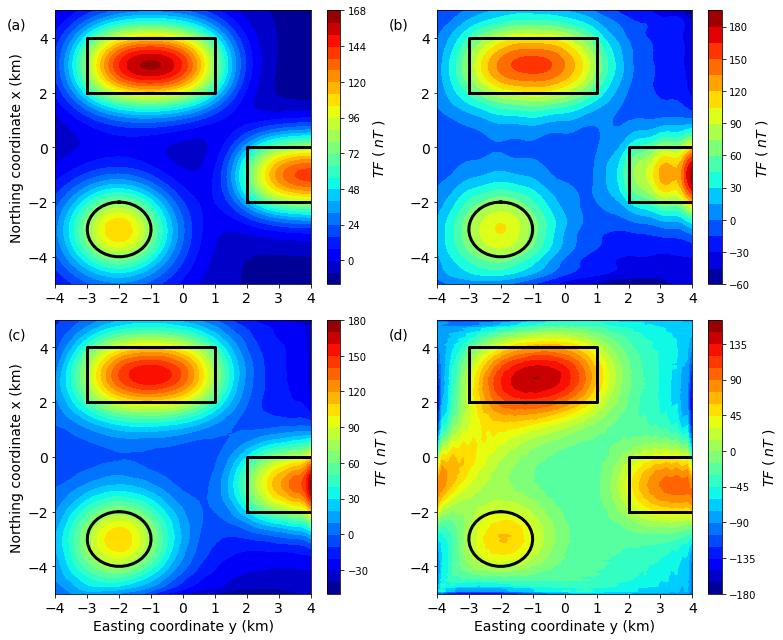

In [44]:
fig = plt.figure(figsize=(11,9))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(221)
plt.title('(a)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_rtp,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(222)
plt.title('(b)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_bccb_rtp,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(223)
plt.title('(c)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_classical_rtp,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(224)
plt.title('(d)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_fourier_rtp,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.tight_layout()
#plt.savefig('rtp_regular.png', dpi=300)

# Save the data

In [45]:
synthetic_regular = dict()
synthetic_regular['x'] = xi_plot
synthetic_regular['y'] = yi_plot
synthetic_regular['z'] = zi
synthetic_regular['tf'] = tf
synthetic_regular['p_c'] = p_c
synthetic_regular['tf_c'] = tf_c
synthetic_regular['delta_tf'] = delta_tf
synthetic_regular['p_bccb'] = p_bccb
synthetic_regular['tf_bccb'] = tf_bccb
synthetic_regular['delta_tf_bccb'] = delta_tf3
synthetic_regular['itmax'] = itmax
synthetic_regular['res_list_ls'] = res_list_ls
synthetic_regular['tf_up'] = tf_up
synthetic_regular['delta_tf_classical_up'] = delta_tf_classical_up
synthetic_regular['delta_tf_bccb_up'] = delta_tf_bccb_up
synthetic_regular['delta_tf_fourier_up'] = delta_tf_fourier_up
synthetic_regular['tf_down'] = tf_down
synthetic_regular['delta_tf_classical_down'] = delta_tf_classical_down
synthetic_regular['delta_tf_bccb_down'] = delta_tf_bccb_down
synthetic_regular['delta_tf_fourier_down'] = delta_tf_fourier_down
synthetic_regular['tf_rtp'] = tf_rtp
synthetic_regular['delta_tf_classical_rtp'] = delta_tf_classical_rtp
synthetic_regular['delta_tf_bccb_rtp'] = delta_tf_bccb_rtp
synthetic_regular['delta_tf_fourier_rtp'] = delta_tf_fourier_rtp

#save the data
file_name = 'synthetic_regular_tf.pickle'
with open(file_name, 'wb') as f:
    pickle.dump(synthetic_regular, f)